<a href="https://colab.research.google.com/github/vaibhavm291/DESIGN-AND-DEVELOPMENT-OF-HYBRID-MODEL-FOR-EFFICIENT-PREDICTION-OF-STOCK-PRICES/blob/main/LSTM(WITHOUT%20FEATURE%20ENGINEERING-RELIANCE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta

In [5]:
# 1. Fetch stock data
ticker = "RELIANCE.NS"  # or "AAPL", "RELIANCE.NS"
today = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start="2020-01-01", end=today)
close_prices = data[["Close"]].values

/tmp/ipython-input-5-1840474079.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end=today)
[*********************100%***********************]  1 of 1 completed


In [6]:
# 2. Normalize the data (important for LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [7]:
# 3. Prepare sequences (e.g., last 60 days to predict 61st)
def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

In [8]:
# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 5. Train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=0)

In [10]:
# 6. Predict tomorrow's price using last 60 days
last_60_days = scaled_data[-60:]  # Last 60 days
last_60_days = np.expand_dims(last_60_days, axis=0)  # Reshape for model
predicted_scaled = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

# 7. Dates
from pandas.tseries.offsets import BDay
last_trading_date = data.index[-1].date()
next_trading_day = last_trading_date + BDay(1)  # Monday if today is Friday/weekend

# 8. Output result
print("📅 Last Trading Day:", last_trading_date)
print("💰 Last Closing Price:", round(close_prices[-1][0], 2))
print("📈 Predicted Price for", next_trading_day.date(), ":", round(predicted_price, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
📅 Last Trading Day: 2025-06-24
💰 Last Closing Price: 1450.8
📈 Predicted Price for 2025-06-25 : 1444.67


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


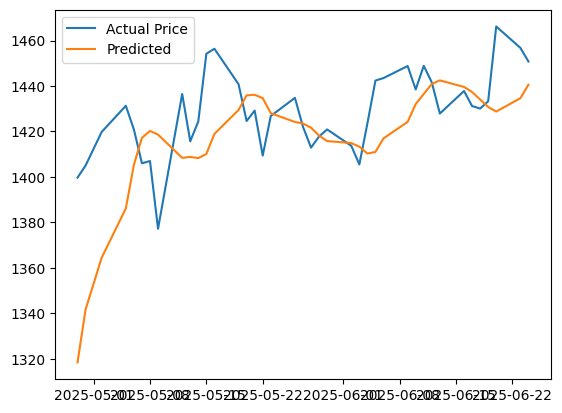

In [11]:
recent_data = data.tail(100)
recent_X = recent_data[["Close"]].values
# Scale the recent data for prediction
scaled_recent_X = scaler.transform(recent_X)

# Prepare sequences for prediction
sequence_length = 60
X_recent = []
for i in range(sequence_length, len(scaled_recent_X)):
    X_recent.append(scaled_recent_X[i-sequence_length:i, 0])

X_recent = np.array(X_recent)
X_recent = np.reshape(X_recent, (X_recent.shape[0], X_recent.shape[1], 1))

recent_preds_scaled = model.predict(X_recent)
recent_preds = scaler.inverse_transform(recent_preds_scaled)

# Plotting
plt.plot(recent_data.index[sequence_length:], recent_data["Close"][sequence_length:], label="Actual Price")
plt.plot(recent_data.index[sequence_length:], recent_preds, label="Predicted")
plt.legend()
plt.show()

In [ ]:
#Reference Paper:
Title: Stock Price Prediction Using LSTM Recurrent Neural Network
Authors: Shun-ichi Amari, Sepp Hochreiter, Jürgen Schmidhuber, et al.
Conference: International Journal of Engineering Research and Applications (IJERA), 2017